In [2]:
import pandas as pd

df = pd.read_csv('data/kidney_disease.csv')

## Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [4]:
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


<Axes: >

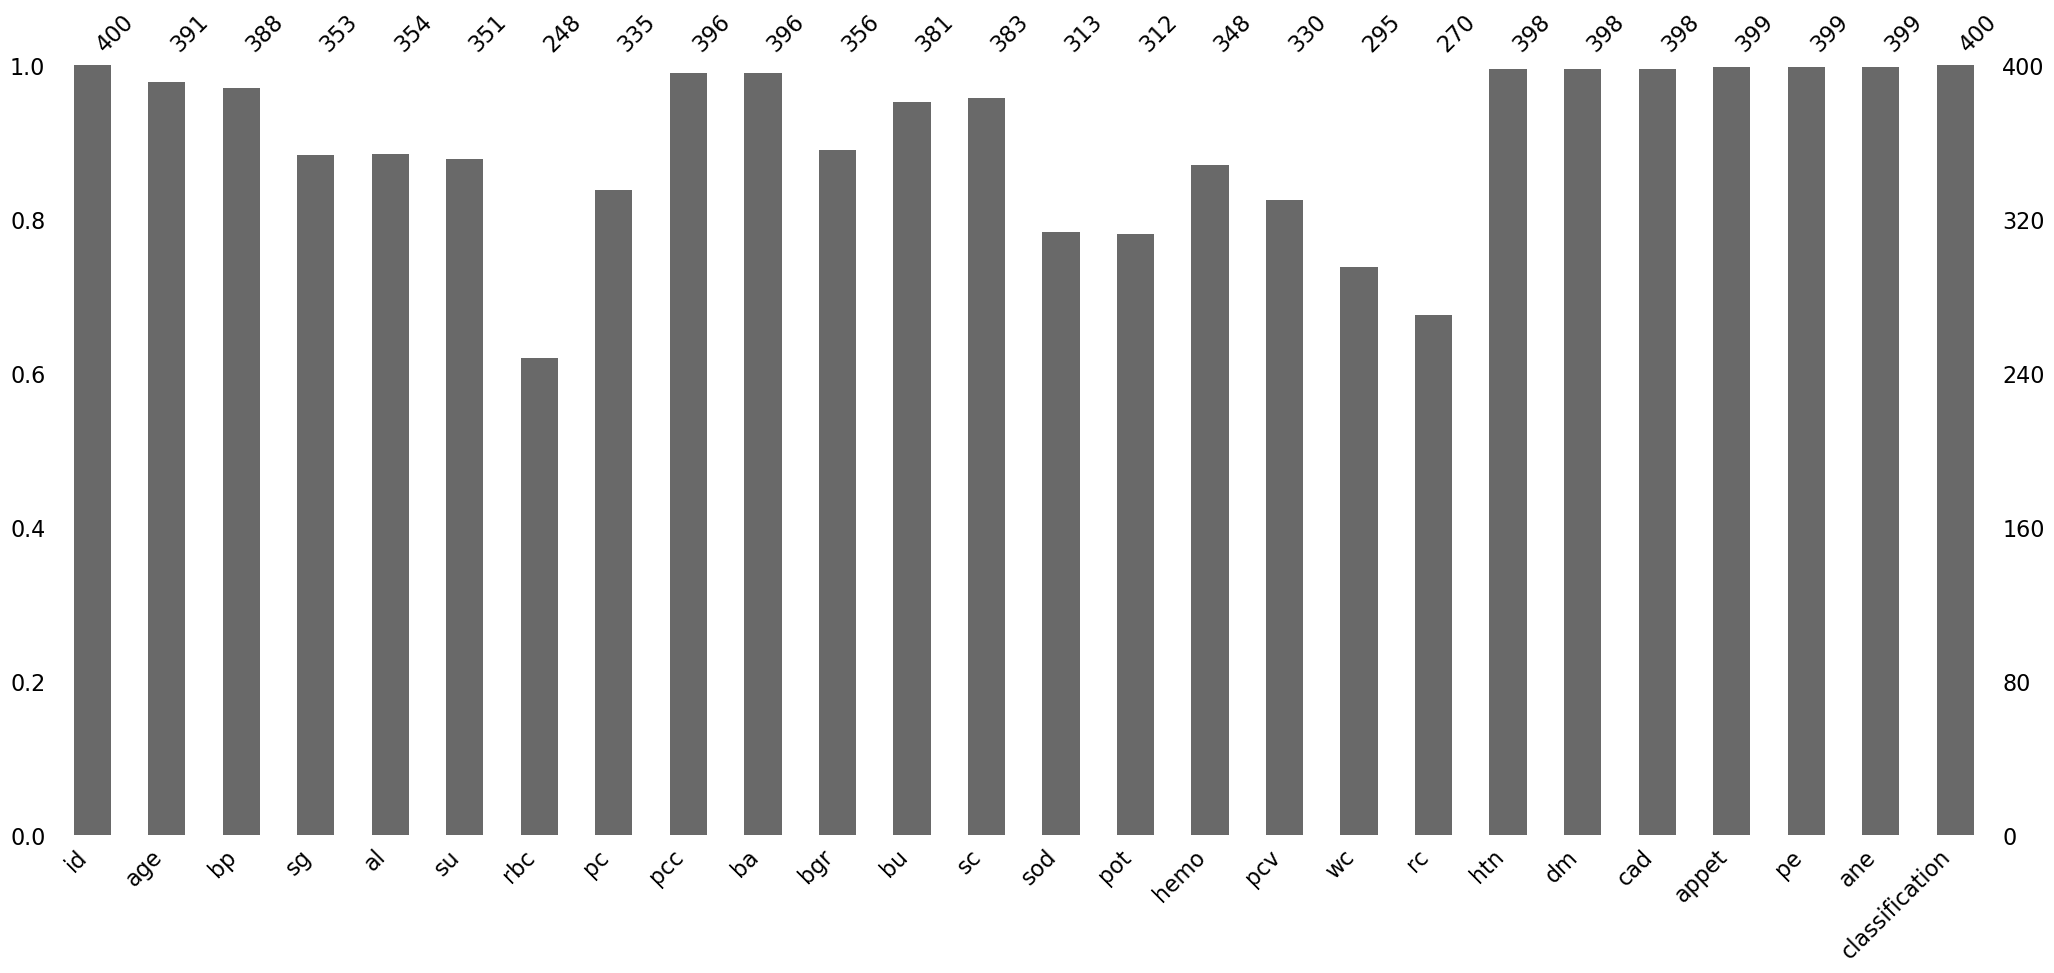

In [5]:
import seaborn as sns
import pandas as pd
import missingno as msno
%matplotlib inline
msno.bar(df)

<Axes: >

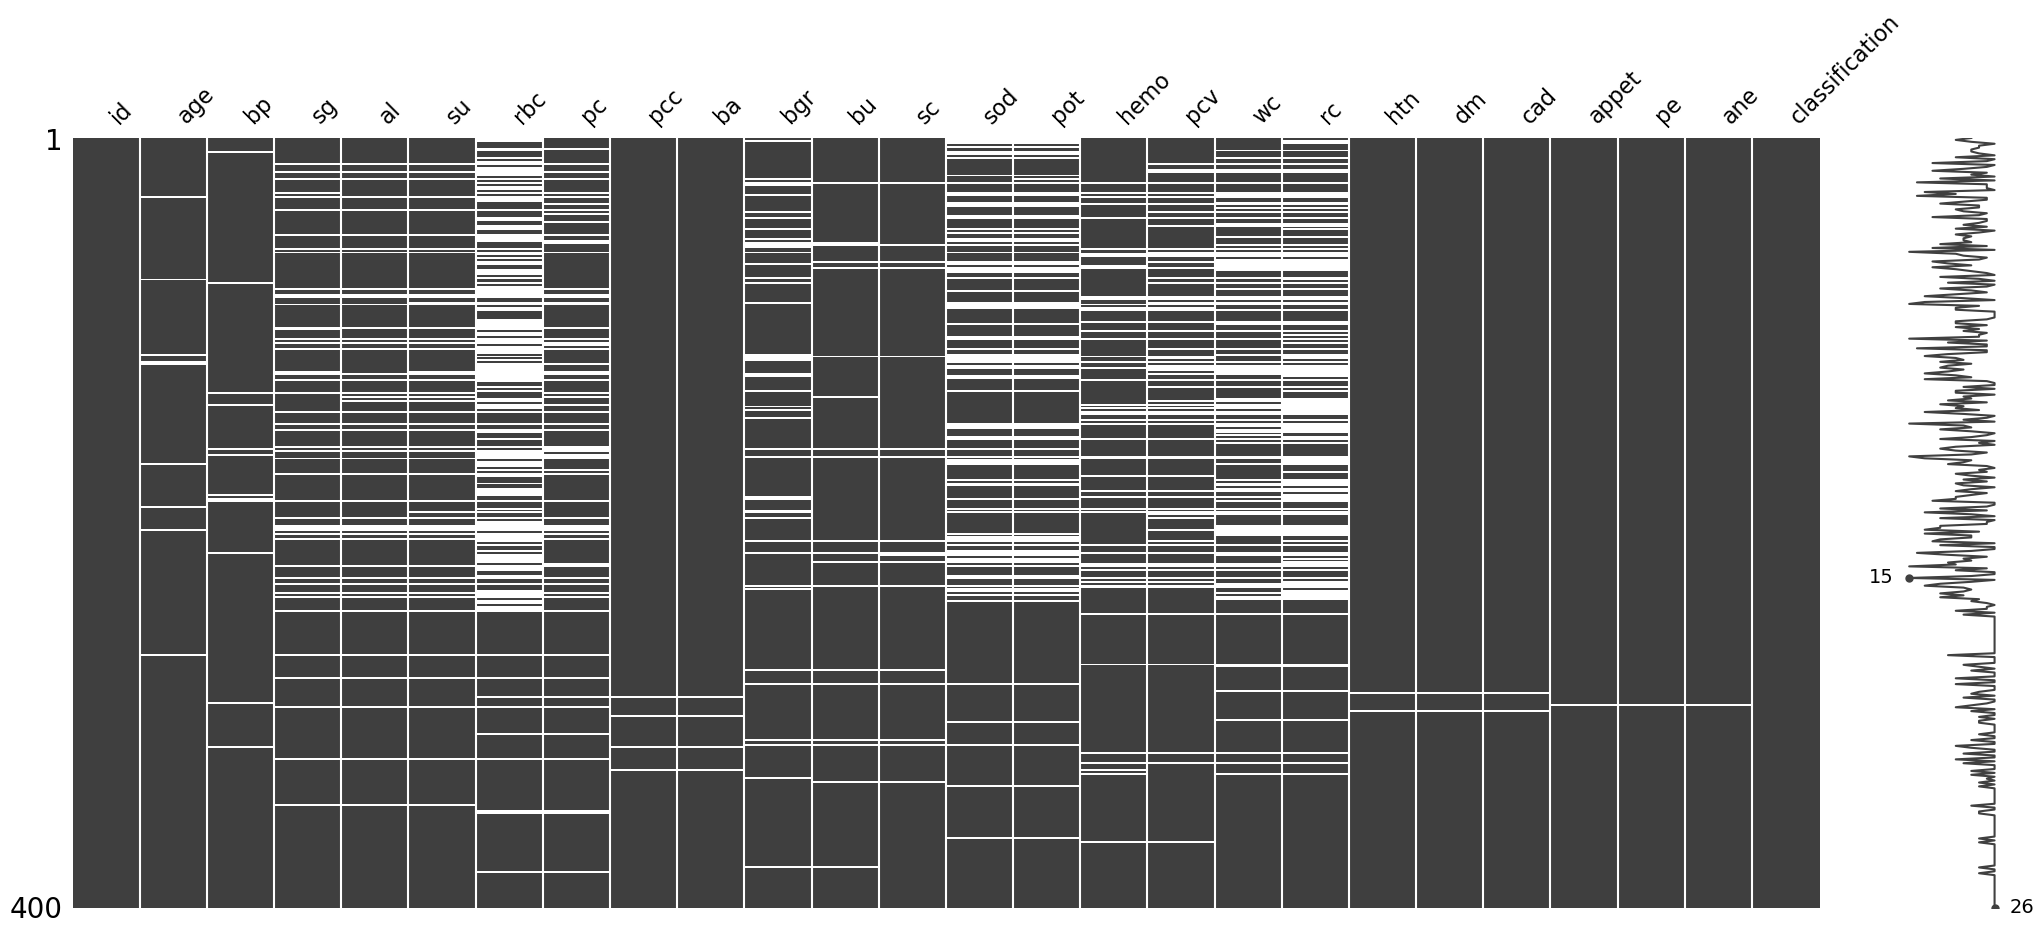

In [6]:
msno.matrix(df)

## Data Labeling

In [16]:
from sklearn import preprocessing

df = df.apply(preprocessing.LabelEncoder().fit_transform)
df

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,40,3,3,1,0,2,1,0,0,...,32,72,34,1,4,1,0,0,0,0
1,1,5,0,3,4,0,2,1,0,0,...,26,56,49,0,3,1,0,0,0,0
2,2,54,3,1,2,3,1,1,0,0,...,19,70,49,0,4,1,1,0,1,0
3,3,40,2,0,4,0,1,0,1,0,...,20,62,19,1,3,1,1,1,1,0
4,4,43,3,1,2,0,1,1,0,0,...,23,68,27,0,3,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,47,3,3,0,0,1,1,0,0,...,35,62,30,0,3,1,0,0,0,2
396,396,34,2,4,0,0,1,1,0,0,...,42,72,44,0,3,1,0,0,0,2
397,397,8,3,3,0,0,1,1,0,0,...,37,61,36,0,3,1,0,0,0,2
398,398,11,1,4,0,0,1,1,0,0,...,39,67,41,0,3,1,0,0,0,2


## Model Training and Comparing

In [35]:
from sklearn.impute import SimpleImputer
from reparo import CDI, FRNNI, HotDeckImputation, KNNImputer, PMM, SICE, MICE
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

imputers = [
    SimpleImputer(strategy='median'),
    SimpleImputer(strategy='mean'),
    SimpleImputer(strategy='most_frequent'),
    SimpleImputer(strategy='constant', fill_value=0),
    CDI(),
    FRNNI(),
    HotDeckImputation(),
    KNNImputer(),
    PMM(),
    SICE(),
    MICE()
]

models = [
    LinearRegression(),
    GaussianNB(),
    DecisionTreeRegressor(),
    RandomForestRegressor()
]

y = df['classification']
X = df.drop('classification', axis=1)
columns = ['Imputation Algorithms', 'Prediction algorithm', 'Accuracy']
table = pd.DataFrame(columns=columns)

for i, imputer in enumerate(imputers): #algorithm for iterating took from a foreign github
    if i < 4:
        imputed_X = imputer.fit_transform(X)
        imputed_X = pd.DataFrame(imputed_X, columns=X.columns)
    else:
        imputed_X = X.copy()
        imputer.apply(imputed_X, imputed_X.columns)

    X_train, X_test, y_train, y_test = train_test_split(imputed_X, y, test_size=0.1, random_state=42)

    for model in models:
        model_str = str(model).split('(')[0]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = model.score(X_test, y_test)

        table = pd.concat([table, pd.DataFrame([[imputer, model_str, accuracy]], columns=columns)], ignore_index=True)

table = table.sort_values(by=['Accuracy'], ascending=False)
table

,Imputation Algorithms,Prediction algorithm,Accuracy
26,HotDeckImputation(),DecisionTreeRegressor,1.000000
42,MICE(),DecisionTreeRegressor,1.000000
34,PMM(),DecisionTreeRegressor,1.000000
6,SimpleImputer(),DecisionTreeRegressor,1.000000
30,KNNImputer(),DecisionTreeRegressor,1.000000
14,"SimpleImputer(fill_value=0, strategy='constant')",DecisionTreeRegressor,1.000000
10,SimpleImputer(strategy='most_frequent'),DecisionTreeRegressor,1.000000
38,SICE(),DecisionTreeRegressor,1.000000
39,SICE(),RandomForestRegressor,0.998794
11,SimpleImputer(strategy='most_frequent'),RandomForestRegressor,0.998423


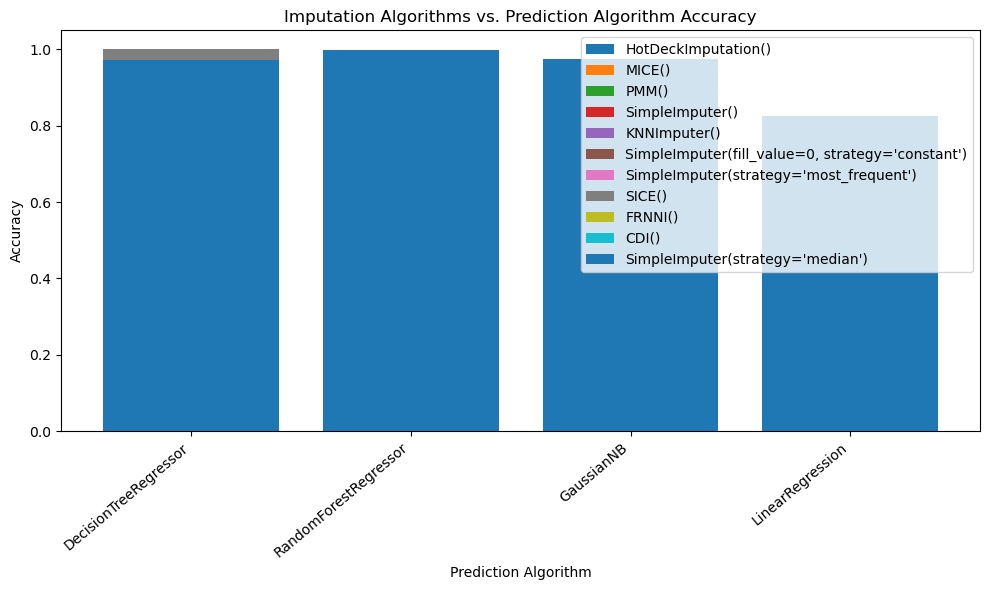

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))

for algo in table['Imputation Algorithms'].unique():
    algo_data = table[table['Imputation Algorithms'] == algo]
    ax.bar(algo_data['Prediction algorithm'], algo_data['Accuracy'], label=str(algo))

ax.set_xlabel('Prediction Algorithm')
ax.set_ylabel('Accuracy')
ax.set_title('Imputation Algorithms vs. Prediction Algorithm Accuracy')
plt.xticks(rotation=40, ha='right')
ax.legend()


plt.tight_layout()
plt.show()

*Note: A lot of inputation algs got the same results thus they overlayed in the plot*

As seen, the highest accuracy was manifested by the SICE() alg, however among all models, Simple Imputer got the advatage.
